In [24]:
#모듈 로딩
# Model 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torchmetrics.classification import F1Score,BinaryF1Score,BinaryAccuracy,BinaryConfusionMatrix, MulticlassF1Score
from torchmetrics.regression import R2Score, MeanSquaredError
from torchinfo import summary

# Data 및 시각화 관련
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

In [25]:
#데이터 로딩
data_file='../data/iris.csv'

#csv -> DataFrame
iris_df=pd.read_csv(data_file)
iris_df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [26]:
labels=dict(zip(iris_df['variety'].unique().tolist(),range(3)))
iris_df['variety']=iris_df['variety'].replace(labels)

iris_df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [27]:
from utils import dynamicModel,make_dataset

In [28]:
model=dynamicModel(4,10,5,3,[10,7],[7,5])
print(model)

dynamicModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (h_layers): ModuleList(
    (0): Linear(in_features=10, out_features=7, bias=True)
    (1): Linear(in_features=7, out_features=5, bias=True)
  )
  (out_layer): Linear(in_features=5, out_features=3, bias=True)
)


In [29]:
feature_df=iris_df[iris_df.columns[:-1]]
target_df=iris_df[iris_df.columns[-1:]]

iris_ds=make_dataset(feature_df,target_df)

iris_dl=DataLoader(iris_ds)
for feature,label in iris_dl:
    print(feature.shape,label.shape, feature,label)
    break

torch.Size([1, 4]) torch.Size([1, 1]) tensor([[5.1000, 3.5000, 1.4000, 0.2000]]) tensor([[0.]])


In [30]:
#학습 진행 관련 설정

EPOCH=1000         #처음에 1로 설정해서 잘 돌아가는지 확인하고 올리기
BATCH_SIZE=10
BATCH_CNT=iris_df.shape[0]//BATCH_SIZE
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
LR=0.001

print(f'BATCH_CNT: {BATCH_CNT}')

BATCH_CNT: 15


In [31]:
#데이터셋 인스턴스
x_train,x_test,y_train,y_test=train_test_split(feature_df,target_df,random_state=1)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,random_state=1)
print(f'x_train: {x_train.shape}, x_test: {x_test.shape}, x_val: {x_val.shape}')
print(f'y_train: {y_train.shape}, y_test: {y_test.shape}, y_val: {y_val.shape}')
print(f'{type(x_train)}, {type(x_test)}, {type(x_val)}')

train_ds=make_dataset(x_train,y_train)
val_ds=make_dataset(x_val,y_val)
test_ds=make_dataset(x_test,y_test)

#최적화 인스턴스
iris_dl=DataLoader(train_ds,batch_size=BATCH_SIZE)

x_train: (84, 4), x_test: (38, 4), x_val: (28, 4)
y_train: (84, 1), y_test: (38, 1), y_val: (28, 1)
<class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>


In [32]:
#최적화 인스턴스: model.parameters() 전달
optimizer=optim.Adam(model.parameters(), lr=LR)

multi_loss=nn.CrossEntropyLoss()

In [33]:
#models 폴더 아래 프로젝트 폴더 아래 모델 파일 저장
save_path='../models/iris/MCF'

save_File='model.train_wbs.pth'

#모델 구조 및 파라미터 모두 저장
save_model='model_all.pth'

In [34]:
#경로 상 폴더 존재 여부 체크
if not os.path.exists(save_path):
    os.makedirs(save_path)  #하위 폴더까지 생성 가능

In [35]:
#학습 확인 w. 손실값, 성능평가 지표

loss_history=[[],[]]
score_history=[[],[]]

CNT = len(iris_dl)
print(f'CNT : {CNT}')

#학습 모니터링/스케줄링 설정: loss_history, score_history 활용
# - 임계 기준: 10번
break_count=0
limit=10

for epoch in range(EPOCH):

    #학습 모드로 모델 설정
    model.train()

    total_loss=0
    total_score=0

    for feature_ts,target_ts in iris_dl:

        #학습 진행
        pre_y=model(feature_ts)

        #손실 계산 w. CrossEntropyLoss (target(정답)이 0차원 또는 1차원, long type이어야 함)
        loss=multi_loss(pre_y,target_ts.reshape(-1).long())
        total_loss+=loss.item()

        #성능 평가
        score=MulticlassF1Score(num_classes=3)(pre_y,target_ts.reshape(-1))
        #score=F1Score(task='binary)(pre_y,target_ts)
        total_score+=score.item()

        #최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #각 에포크 당 검증 수행: 모델을 검증 모드로 설정
    model.eval()

    with torch.no_grad():
        #검증 데이터셋
        val_feature_ts=torch.FloatTensor(val_ds.feature_df.values)
        val_target_ts=torch.FloatTensor(val_ds.target_df.values)
        
        #평가
        pre_val=model(val_feature_ts)

        #손실 계산
        val_loss=multi_loss(pre_val,val_target_ts.reshape(-1).long())

        #성능 평가
        val_score=MulticlassF1Score(num_classes=3)(pre_val,val_target_ts.reshape(-1))

    #손실값, 성능평가값 저장
    loss_history[0].append(total_loss/CNT)
    score_history[0].append(total_score/CNT)

    loss_history[1].append(val_loss)
    score_history[1].append(val_score)

    print(f'[{epoch}/{EPOCH}]\n- Train Loss : {loss_history[0][-1]} Score : {score_history[0][-1]}')
    print(f'- Val Loss : {loss_history[1][-1]} Score : {score_history[1][-1]}')

    #학습 진행 모니터링(스케줄링)_검증 ds 기준 (loss/score 둘 중 하나만 하면 됨)

    # #loss
    # if len(loss_history[1]) >= 2:
    #     if loss_history[1][-1] >= loss_history[1][-2]: break_count+=1

    #score
    if len(score_history[1])>=2:
        if score_history[1][-1] <= score_history[1][-2]: break_count+=1

    #성능이 좋은 학습 가중치 저장
    #save_File=f'model.train_wbs_{epoch}_{val_score}.pth'
    if len(score_history[1])==1:
        #첫번째는 무조건 모델 저장_파라미터만 저장
        torch.save(model.state_dict(),save_path+save_File)
        #모델 전체 저장
        torch.save(model,save_path+save_model)
    else: 
        #두번째부터는 이전보다 성능이 좋으면 저장
        if score_history[1][-1] > max(score_history[1][:-1]):
            torch.save(model.state_dict(),save_path+save_File)
            torch.save(model,save_path+save_model)

    #학습 중단 여부 설정
    if break_count>limit:
        print(f'성능 및 손실 개선이 없어서 {epoch} EPOCH에 학습 중단')
        break

CNT : 9


[0/1000]
- Train Loss : 1.143433067533705 Score : 0.14590594917535782
- Val Loss : 1.0792521238327026 Score : 0.20000000298023224
[1/1000]
- Train Loss : 1.138845509952969 Score : 0.14590594917535782
- Val Loss : 1.0789891481399536 Score : 0.20000000298023224
[2/1000]
- Train Loss : 1.1312792301177979 Score : 0.14590594917535782
- Val Loss : 1.0632892847061157 Score : 0.20000000298023224
[3/1000]
- Train Loss : 1.1068374315897624 Score : 0.14590594917535782
- Val Loss : 1.0261543989181519 Score : 0.20000000298023224
[4/1000]
- Train Loss : 1.0823921759923298 Score : 0.24840838462114334
- Val Loss : 0.9978833794593811 Score : 0.6045548915863037
[5/1000]
- Train Loss : 1.063660654756758 Score : 0.5346690449449751
- Val Loss : 0.9746556878089905 Score : 0.604938268661499
[6/1000]
- Train Loss : 1.0474429726600647 Score : 0.5544498960177103
- Val Loss : 0.953985333442688 Score : 0.604938268661499
[7/1000]
- Train Loss : 1.0311206645435758 Score : 0.5544498960177103
- Val Loss : 0.934061586

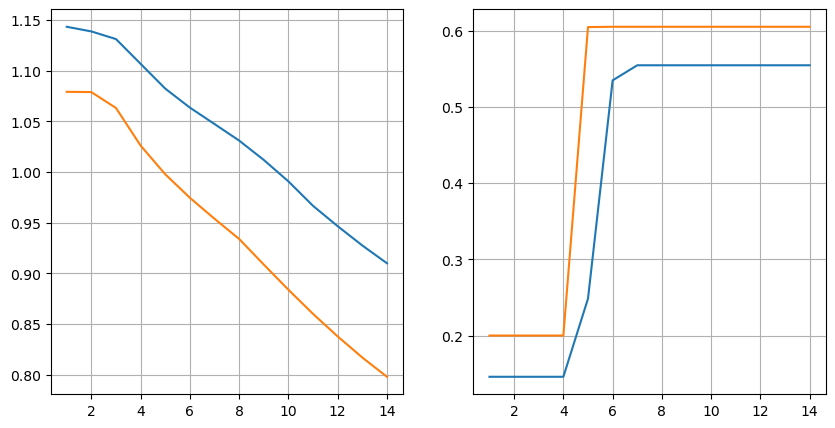

In [36]:
#학습 결과 확인(학습과 검증의 Loss, 성능지표 변화 확인) w. 시각화

th=len(score_history[1])
fg,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1,th+1),loss_history[0][:th],label='Train')
axes[0].plot(range(1,th+1),loss_history[1][:th],label='Val')
axes[0].grid()
axes[0].legend

axes[1].plot(range(1,th+1),score_history[0][:th],label='Train')
axes[1].plot(range(1,th+1),score_history[1][:th],label='Val')
axes[1].grid()
axes[1].legend

plt.show()